## Install needed Libraries

### Install Libraries from pip

In [1]:
!pip install langchain langchain-community pandas numpy matplotlib seaborn nltk textstat

### Import needed Libraries

In [4]:
import pandas as pd
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# Download the needed nltk corpus 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import unicodedata
import textstat
import re

USER_AGENT environment variable not set, consider setting it to identify your requests.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soyel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soyel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\soyel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Convert Excel Spreadsheet to pandas Data Frame

In [7]:
# Read Excel containig List of URL's with Architectural Pattern and Metadata.
url_df = pd.read_excel("./URLs.xlsx", sheet_name="Sheet1")
# Show shape of DataFrame
print("Shape: ",url_df.shape)
# Show the Format of the Data Frame
url_df.head()

Shape:  (628, 6)


,URL,1st Level,2nd Level,3rd Level,4th Level,Lens
0,https://docs.aws.amazon.com/wellarchitected/la...,Abstract and Introducción,NaN,NaN,NaN,Serverless Applications
1,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,NaN,NaN,NaN,Serverless Applications
2,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,Compute Layers,NaN,NaN,Serverless Applications
3,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,Data Layer,NaN,NaN,Serverless Applications
4,https://docs.aws.amazon.com/wellarchitected/la...,Definitions,Messaging and streaming layer,NaN,NaN,Serverless Applications


The data frame shows multiple links where the data is stored. The number of links can be seen in the data frame's shape; we have a total of 628 links.

To obtain additional metadata for each link, we created a structure that includes the name of the AWS Well-Architected Lens in the "Lens" column, and its subsections in the "1st Level," "2nd Level," "3rd Level," and "4th Level" columns. If a link points to information at an upper level, the lower-level columns will display NaN.

## Read each link and store the Data in correct Format

### Create Function to add Level to metadata

In [13]:
# We create a function to validate if a level exist in a row of the dataframe
def createMetadataLevel(level,url_line,metadata):
    #Validate if the Level is enot empty
    if(not pd.isna(url_line[level])):
        #If level is not empty add the level to the metadata
        metadata[level]=url_line[level]
    #Return the modified metadata.
    return metadata

### Create function to load the URL with the extra metadata.

In [16]:
def loadURLWithMetaData(url_line):
    # We define the loader, which will read the information in the URL's leveraging the langchain library.
    loader = WebBaseLoader(
        # We say, which URL will be read and loaded.
        url_line["URL"],
    )
    # We will read the URL and get different documents from all the paragraphs.
    docs = loader.load()
    # We define all the metadata to add to the docs read from this page
    metadata = {
        "Lens": url_line["Lens"],
        "1st Level": url_line["1st Level"]
    }
    # Add all levels of metadata, validating the level exists.
    metadata = createMetadataLevel("2nd Level",url_line,metadata)
    metadata = createMetadataLevel("3rd Level",url_line,metadata)
    metadata = createMetadataLevel("4th Level",url_line,metadata)

    for doc in docs:
        doc.metadata.update(metadata)

    return docs
        
    

### Cycle trough all URL's in the list and load them

In [19]:
#Define Variable to store all information extracted from the URL's with the metadata.
all_docs = []
#Cycle trough all URL's to load them as text and add the desired metadata.
for index, row in url_df.iterrows():
    #Read the content of the URL, add it to the list with it's needed metadata in the propper format, to be able to process it later.
    all_docs.extend(loadURLWithMetaData(row))
print("This is a sample of the content extracted from the URL's", all_docs[0])

This is a sample of the content extracted from the URL's page_content='
Serverless Applications Lens - AWS Well-Architected Framework - Serverless Applications LensServerless Applications Lens - AWS Well-Architected Framework - Serverless Applications LensDocumentationAWS Well-ArchitectedAWS Well-Architected FrameworkIntroductionCustom lens availabilityServerless Applications Lens - AWS Well-Architected FrameworkPublication date: July 14, 2022 (Document revisions)
    This document describes the Serverless Applications Lens for
    the AWS
      Well-Architected Framework. The document covers common
    serverless applications scenarios and identifies key elements to
    ensure that your workloads are architected according to best
    practices.
  
Introduction

      The AWS Well-Architected Framework helps you understand the pros and
      cons of decisions you make while building systems on AWS. By using
      the Framework, you will learn architectural best practices for
      desi

## Convert docs into data frame to perform some discoveries

In [22]:
#Define Function to convert documents into dataframe
def create_dataframe_from_documents(documents):
    # declare variable to store the data
    data = []
    # declare variable to store the metadata
    for doc in documents:
        # define the row as a dictionary from the content
        row = {"page_content": doc.page_content}
        # Add the metadata to the row
        row.update(doc.metadata)
        # Add the row to the list of data
        data.append(row)
    # Return the data frame of all docs
    return pd.DataFrame(data)

### Call function to convert all documents to a dataframe

In [25]:
df_from_docs = create_dataframe_from_documents(all_docs)

## EDA

### Review dataframe general data

#### Review 5 first values of data frame

In [30]:
df_from_docs.head()

,page_content,source,title,description,language,Lens,1st Level,2nd Level,3rd Level,4th Level
0,\nServerless Applications Lens - AWS Well-Arch...,https://docs.aws.amazon.com/wellarchitected/la...,Serverless Applications Lens - AWS Well-Archit...,This document describes the Serverless Applica...,en-US,Serverless Applications,Abstract and Introducción,NaN,NaN,NaN
1,\nDefinitions - Serverless Applications LensDe...,https://docs.aws.amazon.com/wellarchitected/la...,Definitions - Serverless Applications Lens,The AWS Well-Architected Framework is based on...,en-US,Serverless Applications,Definitions,NaN,NaN,NaN
2,\nCompute layer - Serverless Applications Lens...,https://docs.aws.amazon.com/wellarchitected/la...,Compute layer - Serverless Applications Lens,The compute layer of your workload manages req...,en-US,Serverless Applications,Definitions,Compute Layers,NaN,NaN
3,\nData layer - Serverless Applications LensDat...,https://docs.aws.amazon.com/wellarchitected/la...,Data layer - Serverless Applications Lens,The data layer of your workload manages persis...,en-US,Serverless Applications,Definitions,Data Layer,NaN,NaN
4,\nMessaging and streaming layer - Serverless A...,https://docs.aws.amazon.com/wellarchitected/la...,Messaging and streaming layer - Serverless App...,The messaging layer of your workload manages c...,en-US,Serverless Applications,Definitions,Messaging and streaming layer,NaN,NaN


#### Review last 5 Values of the data frame

In [33]:
df_from_docs.tail()

,page_content,source,title,description,language,Lens,1st Level,2nd Level,3rd Level,4th Level
623,\nConclusion - Migration LensConclusion - Migr...,https://docs.aws.amazon.com/wellarchitected/la...,Conclusion - Migration Lens,This lens helps you migrate your workloads to ...,en-US,Migration Lens,Conclusion,NaN,NaN,NaN
624,\nContributors - Migration LensContributors - ...,https://docs.aws.amazon.com/wellarchitected/la...,Contributors - Migration Lens,Contributors to this document include:,en-US,Migration Lens,Contributors,NaN,NaN,NaN
625,\nDocument revisions - Migration LensDocument ...,https://docs.aws.amazon.com/wellarchitected/la...,Document revisions - Migration Lens,Document revisions,en-US,Migration Lens,Document revisions,NaN,NaN,NaN
626,\nNotices - Migration LensNotices - Migration ...,https://docs.aws.amazon.com/wellarchitected/la...,Notices - Migration Lens,Notices,en-US,Migration Lens,Notices,NaN,NaN,NaN
627,\nAWS Glossary - Migration LensAWS Glossary - ...,https://docs.aws.amazon.com/wellarchitected/la...,AWS Glossary - Migration Lens,Lists the latest AWS terminology and usage.,en-US,Migration Lens,AWS Glossary,NaN,NaN,NaN


#### List all the Columns of the Data Frame

In [36]:
df_from_docs.columns

Index(['page_content', 'source', 'title', 'description', 'language', 'Lens',
       '1st Level', '2nd Level', '3rd Level', '4th Level'],
      dtype='object')

#### List general info about the DataFrame

In [39]:
df_from_docs.info

<bound method DataFrame.info of                                           page_content  \
0    \nServerless Applications Lens - AWS Well-Arch...   
1    \nDefinitions - Serverless Applications LensDe...   
2    \nCompute layer - Serverless Applications Lens...   
3    \nData layer - Serverless Applications LensDat...   
4    \nMessaging and streaming layer - Serverless A...   
..                                                 ...   
623  \nConclusion - Migration LensConclusion - Migr...   
624  \nContributors - Migration LensContributors - ...   
625  \nDocument revisions - Migration LensDocument ...   
626  \nNotices - Migration LensNotices - Migration ...   
627  \nAWS Glossary - Migration LensAWS Glossary - ...   

                                                source  \
0    https://docs.aws.amazon.com/wellarchitected/la...   
1    https://docs.aws.amazon.com/wellarchitected/la...   
2    https://docs.aws.amazon.com/wellarchitected/la...   
3    https://docs.aws.amazon.com/wellar

#### General info, including total Count (Null Values)

In [42]:
df_from_docs.describe(include='all')

,page_content,source,title,description,language,Lens,1st Level,2nd Level,3rd Level,4th Level
count,628,628,628,620,628,628,628,550,427,186
unique,628,628,558,594,2,6,41,108,182,183
top,\nServerless Applications Lens - AWS Well-Arch...,https://docs.aws.amazon.com/wellarchitected/la...,Characteristics - Data Analytics Lens,Lists the latest AWS terminology and usage.,en-US,Machine Learning Lens,Well-Architected machine learning\n,ML lifecycle phase - Model development\n,Cost optimization pillar – Best practices\n,Amazon API Gateway
freq,1,1,7,6,627,167,155,43,23,2


With all this information we can confirm the data was extracted succesfully from the different URL's and we can see that the metadata was appended succesfully, we see multipple missing values as expected that will show the relationship between documents and we can confirm all URL's have a parent topic and a Lens seeing no Null values on the Column Lens and Column 1st Level.

### Analyzing Text Content

#### Count of documents for each Lens

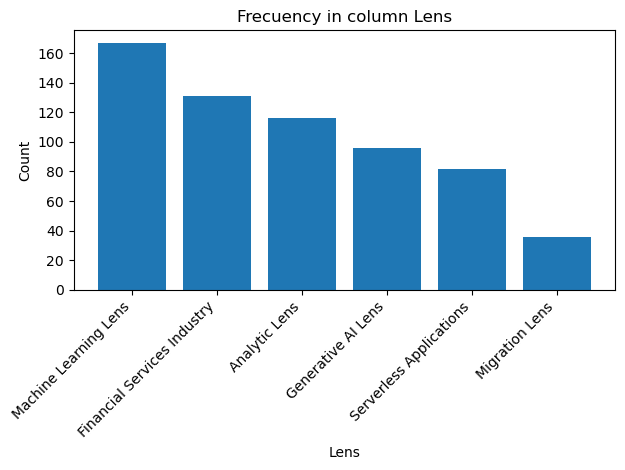

In [47]:
try:
    lens_series = df_from_docs['Lens']
except NameError:
    print("Error: df_from_docs is not defined. Be sure to load your DataFrame before running this code.")
else:
    # Conteo de ocurrencias de cada valor
    counts = lens_series.value_counts()

    # Generar la gráfica de barras
    fig, ax = plt.subplots()
    ax.bar(counts.index, counts.values)
    ax.set_xlabel('Lens')
    ax.set_ylabel('Count')
    ax.set_title('Frecuency in column Lens')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Text Length

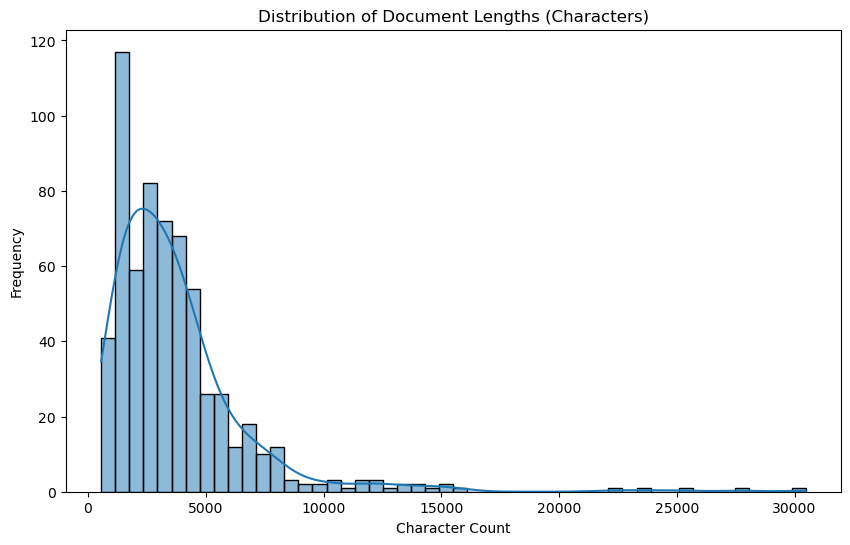

In [50]:
# Adding a column to the dataframe that contains the length of each sentence.
df_from_docs['content_length'] = df_from_docs['page_content'].apply(len)
#Define size of the plot to make
plt.figure(figsize=(10, 6))
# Create Histogram showing the length of the sentences
sns.histplot(df_from_docs['content_length'], bins=50, kde=True)
# Add title to the Histogram
plt.title('Distribution of Document Lengths (Characters)')
# Add title to the X axis
plt.xlabel('Character Count')
# Add title to the u axis
plt.ylabel('Frequency')
# Show histogram
plt.show()

By analyzing the shape of the graph, we can observe that the distribution of document lengths is highly skewed. This indicates the presence of both very short and very long texts. However, most documents fall within a shorter range, with an average length of approximately 500 words. This insight will be valuable for determining an appropriate chunk size in the next phase of data preprocessing.

#### Vocabulary Analysis

##### Define function to get top N words

In [55]:
# Declare the stopwords, so we can ignore the ost common words in english vocabulary that do not add much sense to the senteces
stop_words = set(stopwords.words('english'))
stop_words.add("aws")
stop_words.add("amazon")
stop_words.add("us")
#Define the fucntion to generate the top N words
def get_top_n_words(docs, n=20):
    # Tokenize the words in the corpus
    word_tokens = [word.lower() for doc in docs for word in word_tokenize(doc) if word.isalpha() and word.lower() not in stop_words]
    # Count the times a word appears
    word_counts = Counter(word_tokens)
    # Return the Top n words
    return word_counts.most_common(n)

##### Get the 20 most common words

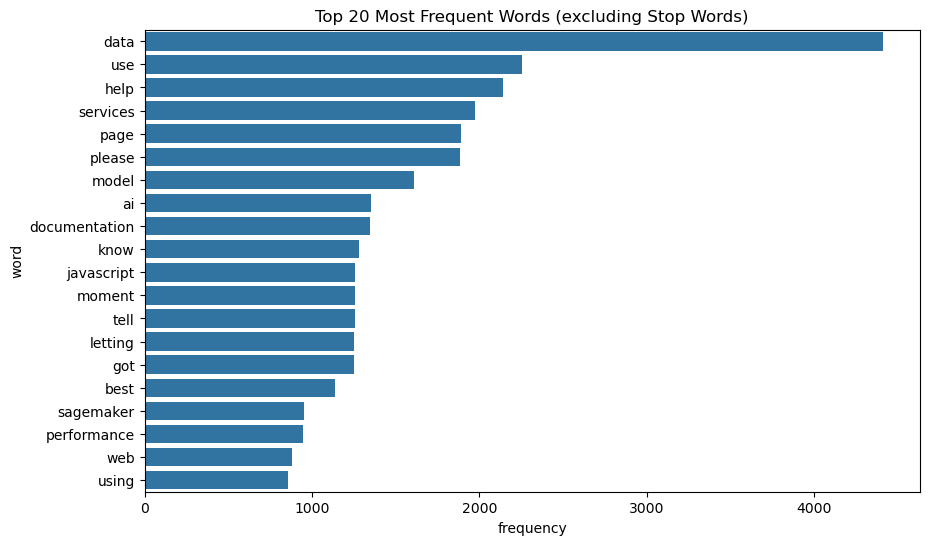

In [58]:
# Get the top words from all the documents
top_words = get_top_n_words(df_from_docs['page_content'])
# Create a new dataframe containing the word and the frquency of each word
df_top_words = pd.DataFrame(top_words, columns=['word', 'frequency'])
# Define plot size
plt.figure(figsize=(10, 6))
# Create Bar Plot to show the Most common words in a graph
sns.barplot(x='frequency', y='word', data=df_top_words)
# Add title to the graph
plt.title('Top 20 Most Frequent Words (excluding Stop Words)')
# SHow the graph
plt.show()

From the chart, we observe that the most frequent word is "data", followed closely by "use", "help", and "services", each appearing over 1,000 times. This makes sense given the context, as architectural patterns are designed to recommend cloud services that can be leveraged based on specific requirements. The frequency of these terms confirms that the dataset contains relevant and actionable content aligned with our use case.

#### Readability

##### Define function to get redability scores

In [63]:
#define Function to calculate readability
def calculate_readability(text):
    try:
        #Define the scores to calculate from the received text
        scores = {
            "flesch_reading_ease": textstat.flesch_reading_ease(text),
            "smog_grade": textstat.smog_index(text),
        }
        # Return the value of the scores
        return scores
    # Throw exception when there is an error
    except Exception as e:
        # #Return the error value
        return {"error": str(e)}


##### Calculate ease of reading metrics

In [68]:
# Add a new column to the data frame with all the redability metrics per document
df_from_docs['readability_scores'] = df_from_docs['page_content'].apply(calculate_readability)
# Create a new dataframe containing only the readability metrics in separete columns
readability_df = pd.json_normalize(df_from_docs['readability_scores'])
# Add the metrics in separete columns to the original data frame
df_from_docs = pd.concat([df_from_docs, readability_df], axis=1).drop(columns=['readability_scores'])
# print the metrics
print("Readability Scores (using textstat):")
print(df_from_docs.describe())

Readability Scores (using textstat):
       content_length  flesch_reading_ease  smog_grade  flesch_reading_ease  \
count      628.000000           628.000000  628.000000           628.000000   
mean      3752.812102            29.630048   14.826274            29.630048   
std       3167.142626            11.734717    2.141180            11.734717   
min        557.000000           -58.800000   10.800000           -58.800000   
25%       1736.500000            24.222500   13.600000            24.222500   
50%       3047.000000            30.570000   14.650000            30.570000   
75%       4474.250000            37.500000   15.725000            37.500000   
max      30472.000000            52.700000   30.700000            52.700000   

       smog_grade  
count  628.000000  
mean    14.826274  
std      2.141180  
min     10.800000  
25%     13.600000  
50%     14.650000  
75%     15.725000  
max     30.700000  


We see in general the text is relative complex to understand and this alligns with the expectations the flesh_reading ease of 32 in average tells us that the text are intended to be read by a college studemt or above. So this makes sense as the data is very technical so we are expecting the inputs to be very technical as well, this is something to consider when creating prompts as if the prompts are very simple this might cause an issue, this might need to us to be sure the metadat is helpfull enough to pull the right information. We can confirm this with a smog_grade of 13, that alligns with the level of education expected to understaand the text. 
As this model is going to be utilized by profesionals in IT it is expected they will be able to provide the complex enoughh queries.

In [83]:
def identify_potential_issues(text, html_threshold=5, char_threshold=10, min_words=5, repetition_ngram=6):
    """Identifies potential quality issues in a text block."""
    issues = {}

    # Normalize Unicode (e.g., accented characters)
    normalized_text = unicodedata.normalize('NFKC', text)

    # Check for excessive HTML tags
    html_tags = re.findall(r"<[^>]+>", normalized_text)
    if len(html_tags) > html_threshold:
        issues["excessive_html_tags"] = f"Found {len(html_tags)} HTML tags"

    # Detect unusual or special characters (excluding common punctuation)
    special_chars = re.findall(r"[^\w\s.,?!'\"()\-:/]", normalized_text)
    if len(special_chars) > char_threshold:
        issues["unusual_characters"] = f"Found {len(set(special_chars))} unusual characters: {''.join(set(special_chars))}"

    # Check for very short content
    word_count = len(normalized_text.split())
    if word_count < min_words:
        issues["very_short_content"] = f"Content has only {word_count} words"

    # Repetition check using n-grams
    tokens = [word.lower() for word in word_tokenize(normalized_text) if word.isalpha()]
    tokens_clean = [t for t in tokens if t not in stopwords.words('english')]

    if len(tokens_clean) > 10:
        ngrams = [' '.join(tokens_clean[i:i+repetition_ngram]) for i in range(len(tokens_clean) - repetition_ngram + 1)]
        ngram_counts = Counter(ngrams)
        repeated_phrases = {k: v for k, v in ngram_counts.items() if v > 20}
        if repeated_phrases:
            issues["repetitive_phrases"] = f"Repeated phrases: {list(repeated_phrases.keys())[:3]}"

    # Check for poor readability
    try:
        readability_score = textstat.flesch_reading_ease(normalized_text)
        if readability_score < 30:  # Very difficult to read
            issues["low_readability"] = f"Flesch Reading Ease score is low: {readability_score}"
    except:
        issues["readability_error"] = "Unable to calculate readability"

    return issues


In [85]:
df_from_docs["text_issues"] = df_from_docs["page_content"].apply(identify_potential_issues)

C:\Users\soyel\AppData\Local\Temp\ipykernel_31948\2815153752.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_issues_plot, x='Count', y='Issue Type', palette='muted')


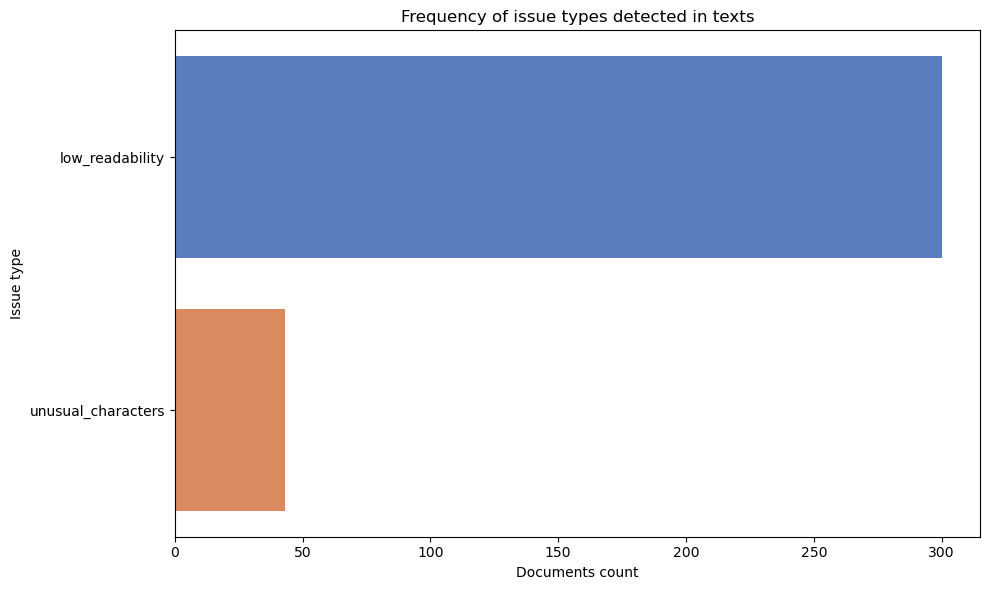

In [86]:
# Count how many documents has each type of issue.
issue_counts = Counter(
    issue
    for issues in df_from_docs["text_issues"]
    for issue in issues.keys()
)

df_issues_plot = pd.DataFrame(issue_counts.items(), columns=['Issue Type', 'Count'])

# Plotting bar plot to see issues distribution.
plt.figure(figsize=(10, 6))
sns.barplot(data=df_issues_plot, x='Count', y='Issue Type', palette='muted')
plt.title('Frequency of issue types detected in texts')
plt.xlabel('Documents count')
plt.ylabel('Issue type')
plt.tight_layout()
plt.show()

This chart summarizes the most common quality issues identified in the analyzed texts. The most frequent issue is repetitive phrases, indicating potential redundancy or overuse of certain expressions, which may impact the clarity and conciseness of the content. Low readability is also prominent, suggesting that many documents may be too complex or difficult to process, especially for generative models. A smaller portion of the texts contain unusual characters, which may point to encoding problems or artifacts from HTML or web scraping. These insights will guide our data cleaning and refinement strategy in the next preprocessing phase.